The QConv layer implemented in this notebook is from:
[A Tutorial on Quantum Convolutional Neural
Networks (QCNN)](https://arxiv.org/pdf/2009.09423.pdf)

Also only Qconv layers have been used, without any quatum pooling layer.

The following circuit has been used to encode classical data into qubits and apply the quantum convolutional layer:-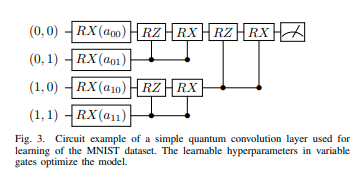

In [27]:
!pip install -q tensorflow==2.3.1

In [28]:
!pip install -q tensorflow-quantum

In [29]:
import numpy
data = numpy.load('/content/electron-photon.npz')
print(data.files)

['x_train', 'y_train', 'x_test', 'y_test']


In [30]:
print("Shapes of the files:-\n")
for file in data.files:
  print("%s---%s" %(file,(str(data[file].shape))))

Shapes of the files:-

x_train---(100, 32, 32)
y_train---(100,)
x_test---(100, 32, 32)
y_test---(100,)


In [31]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [32]:

(x_train, y_train), (x_test, y_test) = (data['x_train'],data['y_train']),(data['x_test'],data['y_test'])


x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 100
Number of original test examples: 100


In [33]:
x_train= tf.cast(x_train, tf.float32)
x_test=tf.cast(x_test, tf.float32)

# x_train = tf.image.resize(x_train[:], (10,10)).numpy()
# x_test = tf.image.resize(x_test[:], (10,10)).numpy()

y_train = y_train[:]
y_test = y_test[:]

1.0


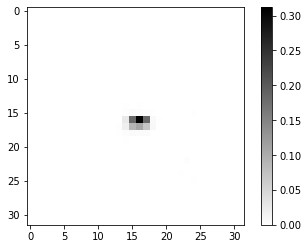

In [34]:
print(y_train[0])
fig = plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray_r')
plt.colorbar()
# fig.savefig('sample', dpi=300)

# Fully Connected layer only

In [47]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

fc_model = models.Sequential()

fc_model.add(layers.Flatten(input_shape=(width,height,1)))
fc_model.add(layers.Dense(32, activation='relu'))
fc_model.add(layers.Dense(2, activation='softmax'))

In [48]:

fc_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fc_history = fc_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
4/4 [==============================] - 0s 35ms/step - loss: 0.6920 - accuracy: 0.5600 - val_loss: 0.6955 - val_accuracy: 0.4600
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6894 - accuracy: 0.5600 - val_loss: 0.6947 - val_accuracy: 0.4600
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6876 - accuracy: 0.5600 - val_loss: 0.6945 - val_accuracy: 0.4600
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.5600 - val_loss: 0.6946 - val_accuracy: 0.4600
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6830 - accuracy: 0.5600 - val_loss: 0.6957 - val_accuracy: 0.4600
Epoch 6/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6801 - accuracy: 0.5600 - val_loss: 0.6969 - val_accuracy: 0.4600
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6780 - accuracy: 0.5600 - val_loss: 0.6989 - val_accuracy: 0.4600
Epoch 8/50
4/4 [=================

In [49]:
test_loss, test_acc = fc_model.evaluate(x_test, y_test, verbose=2)

4/4 - 0s - loss: 0.7027 - accuracy: 0.5400


# Convolution Layer

In [50]:

width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(16, (2, 2), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

In [51]:
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        2064      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [53]:
cnn_model.compile(optimizer=tf.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

cnn_history = cnn_model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 56ms/step - loss: 0.5663 - accuracy: 0.7200 - val_loss: 0.8348 - val_accuracy: 0.4700
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 0.5725 - accuracy: 0.6800 - val_loss: 0.8472 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 0.5590 - accuracy: 0.7200 - val_loss: 0.8151 - val_accuracy: 0.4900
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.5790 - accuracy: 0.7100 - val_loss: 0.8287 - val_accuracy: 0.4900
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 0.5722 - accuracy: 0.7200 - val_loss: 0.8119 - val_accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 0.5490 - accuracy: 0.7400 - val_loss: 0.8250 - val_accuracy: 0.4800
Epoch 7/100
4/4 [==============================] - 0s 23ms/step - loss: 0.5742 - accuracy: 0.6500 - val_loss: 0.8409 - val_accuracy: 0.5000
Epoch 8/100
4/4 [===

In [54]:

test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)

4/4 - 0s - loss: 0.8453 - accuracy: 0.4800


# QConv Layer

In [23]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        pixels = self.filter_size**2
        # filter size: 2^n only for this version!
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        
    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y] 
            
        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
          
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)
        
    

In [24]:

width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

qcnn_model = models.Sequential()


qcnn_model.add(QConv(filter_size=2, depth=8, activation='relu', 
                     name='qconv1', input_shape=(width, height, 1)))


qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
qcnn_model.add(layers.Dense(2, activation='softmax'))

In [25]:
qcnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
qconv1 (QConv)               (None, 31, 31, 8)         48        
_________________________________________________________________
flatten_2 (Flatten)          (None, 7688)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                246048    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 246,162
Trainable params: 246,162
Non-trainable params: 0
_________________________________________________________________


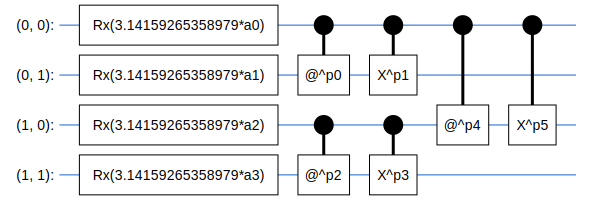

In [26]:
SVGCircuit(QConv(filter_size=2, depth=0, activation='relu').circuit)

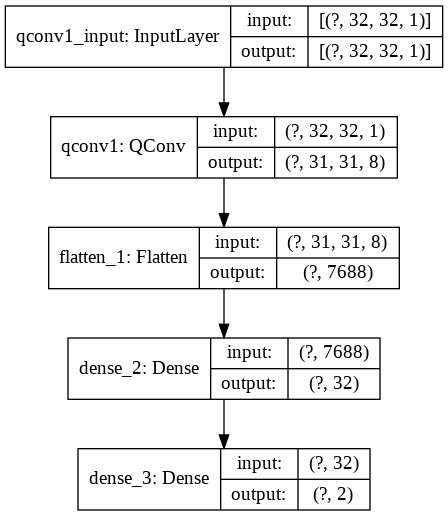

In [21]:

import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(qcnn_model, to_file='model_shapes.png', show_shapes=True)

In [115]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
4/4 [==============================] - 139s 35s/step - loss: 0.6924 - accuracy: 0.5600 - val_loss: 0.6997 - val_accuracy: 0.4600
Epoch 2/50
4/4 [==============================] - 129s 32s/step - loss: 0.6839 - accuracy: 0.5600 - val_loss: 0.7133 - val_accuracy: 0.4600
Epoch 3/50
4/4 [==============================] - 130s 32s/step - loss: 0.6820 - accuracy: 0.5600 - val_loss: 0.7229 - val_accuracy: 0.4600
Epoch 4/50
4/4 [==============================] - 138s 34s/step - loss: 0.6786 - accuracy: 0.5600 - val_loss: 0.7231 - val_accuracy: 0.4600
Epoch 5/50
4/4 [==============================] - 132s 33s/step - loss: 0.6729 - accuracy: 0.5600 - val_loss: 0.7104 - val_accuracy: 0.4600
Epoch 6/50
4/4 [==============================] - 130s 32s/step - loss: 0.6654 - accuracy: 0.5600 - val_loss: 0.7092 - val_accuracy: 0.4700
Epoch 7/50
4/4 [==============================] - 130s 33s/step - loss: 0.6599 - accuracy: 0.5600 - val_loss: 0.7158 - val_accuracy: 0.4700
Epoch 8/50
4/4 [====

In [149]:
    
def plot_loss_curves(qcnn_loss_train,qcnn_loss_test):
  fig = plt.figure()
  plt.plot(np.arange(len(qcnn_loss_train))[::2] + 1, qcnn_loss_train[::2], "b*-", label="train")
  plt.plot(np.arange(len(qcnn_loss_test))[::2] + 1, qcnn_loss_test[::2], "r*-", label="test")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 50, 0, 1])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.grid(True)
  fig.savefig('loss.png', dpi=300)

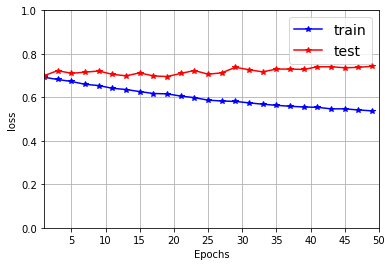

In [150]:
plot_loss_curves(qcnn_history.history['loss'],qcnn_history.history['val_loss'])


In [153]:
def plot_acc_curves(qcnn_acc_train,qcnn_acc_test):
    fig = plt.figure()
    plt.plot(np.arange(len(qcnn_acc_train))[::2] + 1, qcnn_acc_train[::2], "b^-", label="train")
    plt.plot(np.arange(len(qcnn_acc_test))[::2] + 1, qcnn_acc_test[::2], "r^-", label="test")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    fig.savefig('accuracy.png', dpi=300)

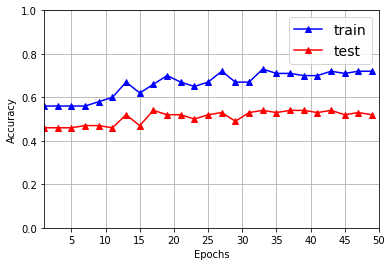

In [154]:
plot_acc_curves(qcnn_history.history['accuracy'],qcnn_history.history['val_accuracy'])